# Exercises

In [1]:
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import psutil
from pathlib import Path
import os

# CaImAn funtions and objects
import caiman as cm
from caiman.motion_correction import MotionCorrect, high_pass_filter_space
from caiman.source_extraction.cnmf import params as params
from caiman.source_extraction import cnmf
from caiman.source_extraction.cnmf.cnmf import load_CNMF
from caiman.utils.visualization import plot_contours

import sys
import os
sys.path.append(os.path.abspath("code"))
from utils import download_data
import auxiliary_functions as aux


import seaborn as sns
sns.set_theme(context='notebook',style='white',font_scale=1.5)


## Exercise 1: Image characteristics
---

**A.** Distiguishing pixels   

Fluctuations in the activitation of the neuron can be directly observed on the video or in a temporal trace plot of each pixel. Plotting the temporal trace will allow us to see the calcium transient dinamic, if a pixel belonging to a neuron is selected. 

* Select a set of *N* random pixels from the ROI and plot the temporal evolution of pixel value. If the random pixels are choosen from an active neuron, you will be able to see the calcium transcient dynamic. Try this a few time to appreciate the results.

**B.** Temporal statistics of pixel activation
 * For the selected pixels, plot the histogram of pixel value. What are the difference in different regions?, and how can that help to distinguish a pixel that belongs to aneuron from a background pixel?

* If we can already see the calcium traces from individual pixels, why do we need to run source extraction to segment the neurons? Why, as a starter, would not be a good idea to work directly with the temporal traces of the pixels? 

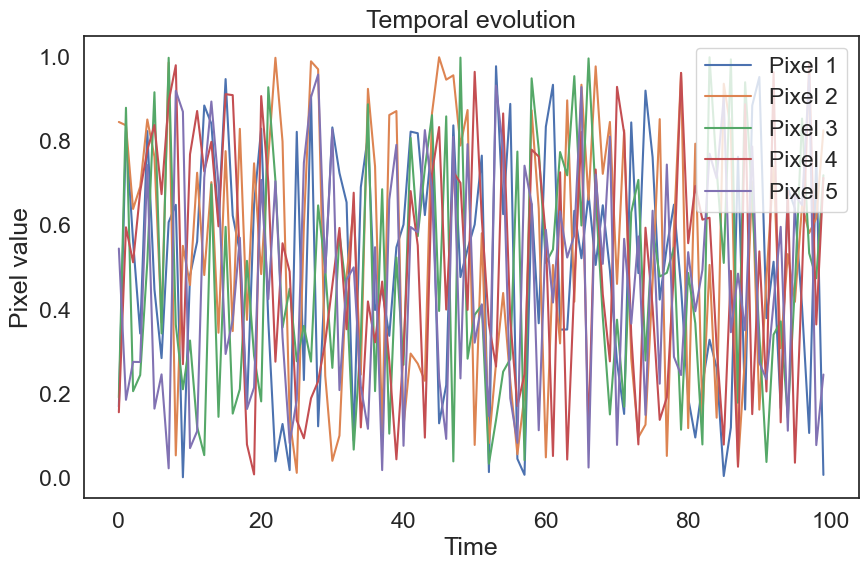

In [29]:
def generate_data_pixel(num_pixels, num_frames):
    return np.random.rand(num_pixels, num_frames)

def plot_evolucion_pixel(data_pixel):
    num_pixels, num_frames = datos_pixel.shape
    tiempo = np.arange(num_frames)
    
    plt.figure(figsize=(10, 6))
    for i in range(num_pixels):
        plt.plot(tiempo, datos_pixel[i], label=f'Pixel {i+1}')
    
    plt.xlabel('Time')
    plt.ylabel('Pixel value')
    plt.title('Temporal evolution')
    plt.legend()
    plt.show()

# Parameters
N = 5  # Number of random parameters
num_frames = 100  # Number of temporal points

datos_pixel = generar_datos_pixel(N, num_frames)

# Trazar la evolución temporal de los píxeles
plot_evolucion_pixel(datos_pixel)

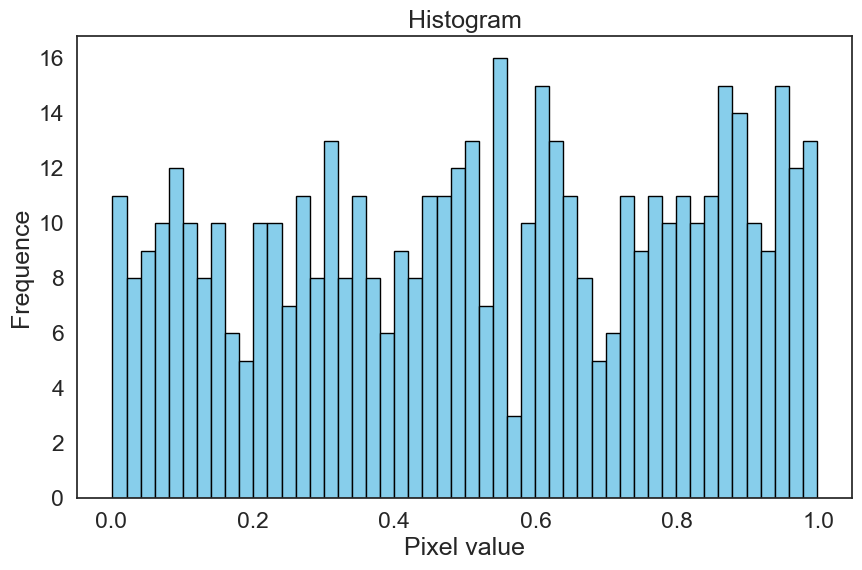

In [28]:
def plot_histograma_pixel(datos_pixel):
    plt.figure(figsize=(10, 6))
    plt.hist(datos_pixel.flatten(), bins=50, color='skyblue', edgecolor='black')
    plt.xlabel('Pixel value')
    plt.ylabel('Frequence')
    plt.title('Histogram')
    plt.show()

plot_histograma_pixel(datos_pixel)


Pixels that come from an alive neuron have different distributions compared to the pixels from the background. The pixels from alive neurons may have higher values of pixels rather than the background ones as there is more quantity of calcium present during neural activity.

We need to run source extraction to segment the neurons because it allows us to indetify and separate the neural signals from other noise sources or background signals. Working directly with temporal segments may be problematic because individual segments might get mixed with background noise and other signals not related to neural activity, which difficults the interpretation of the results.

## Exercise 2: motion correction parameters
---

One parameter that impacts motion correction performance is the size of the spatial filter that is applyed to the video.

* Use the following function from CaImAn and plot the result of different space filtering applyed to a single frame of the video:from caiman.motion_correction import high_pass_filter_space

* How will this filtering affect the measure of crispness?

* Acording to Pnevmatikakis et al, which other factors are relevant for pw-rigid motion correction?

- Explore the impact of different parameters in the output of motion correction algorithm by measuring crispness in the correlation image of the final outcome. Particularly measure the effect of different spatial filter size by applying motion correction algorithm multiple times and computing the crispness of the output video. 

- Display all crispness values for rigid and not rigid motion correction and plot them agains gSig_filters values.

- If possible, show the impact of the crispness value that comes from changing other relevant paraments.

*Note1: The is no need to save all the motion corrected movies, just save the cripsness values.*

*Note2: gSig_filters is an optional range of posible values, but if your computer gets to slow in the computation reduce the range.*


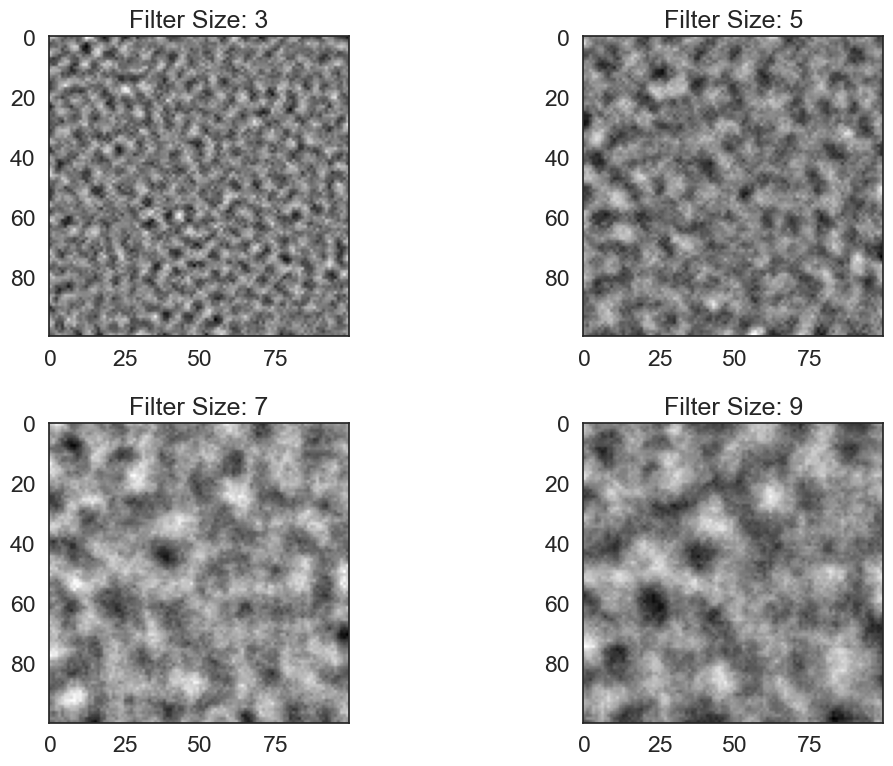

In [4]:
frame = np.random.rand(100, 100)
filter_sizes = [3, 5, 7, 9]

plt.figure(figsize=(12, 8))
for i, size in enumerate(filter_sizes):
    filtered_frame = high_pass_filter_space(frame, (size, size))
    plt.subplot(2, 2, i+1)
    plt.imshow(filtered_frame, cmap='gray')
    plt.title(f'Filter Size: {size}')
plt.tight_layout()
plt.show()

2.Spatial filtering can impact crispness by altering the gradient field of the image. Smoothing filters may reduce noise but could also blur important details, potentially decreasing crispness. Conversely, filters that enhance relevant features might improve crispness.

3. Other factors relevant for pw-rigid motion correction (Pnevmatikakis et al.) include temporal filtering, motion model selection, regularization techniques, and quality metrics.

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import sobel

# Cripsness of the image
def calculate_crispness(summary_image):
    gradient_x = sobel(summary_image, axis=0)
    gradient_y = sobel(summary_image, axis=1)
    gradient_norm = np.sqrt(gradient_x**2 + gradient_y**2)
    crispness = np.linalg.norm(gradient_norm)
    return crispness

winsize = 100
swap_dim = False
resize_fact_flow = 0.1

tmpl_orig = np.random.rand(100, 100)  
tmpl_rig = np.random.rand(100, 100)   
tmpl_els = np.random.rand(100, 100)  


crispness_orig = calculate_crispness(tmpl_orig)
crispness_rig = calculate_crispness(tmpl_rig)
crispness_els = calculate_crispness(tmpl_els)


print("Crispness original:", crispness_orig)
print("Crispness after rigid motion correction:", crispness_rig)
print("Crispness after non-rigid motion correction:", crispness_els)


Crispness original: 142.00010196821455
Crispness after rigid motion correction: 141.4259457550909
Crispness after non-rigid motion correction: 142.68321712740308


## Exercise 3: Source extraction parameters 
---

* For a fixed minimum correlation value (ie 0.6) select a range of possible PNR minimun values and study the impact of those in the final source extraction output.

* For a fixed value of PNR (ie 6) select a range of minimum correlation valur and study the impact of those in the final source extraction output.

* How do these paramenters affect the spatial sparcity of the output? Which set of parameter selection procedes the higher number of neurons? Is maximal number of neurons always better? Why?  

* Generate a plot of number of neurons vs PNR (or min corr value) to show how these parameters affect the source extracted signals.

* Are the temporal traces affected by these parameters?

* For different PNR and minimum correlation value plot the correlation image and the selected cells.

In [22]:
def perform_source_extraction(file_name, pnr, min_corr):
    params_dict = {
        'fnames': file_name,
        'fr': 30,            
        'decay_time': 0.4,  
        'gSig': [4, 4],      
        'p': 1,             
        'nb': 2,             
        'rf': 15,            
        'stride': 6,         
        'K': None,           
        'method_init': 'greedy_roi', 
        'min_corr': min_corr, 
        'min_pnr': pnr,      
        'ssub': 2,           
        'tsub': 2           
    }
    
    params = CNMFParams(params_dict=params_dict)
    cnm = CNMF(n_processes=1, params=params)
    cnm.fit_file(file_name)
    return len(cnm.estimates.C), cnm

def analyze_neurons(cnm, title):
    Cn = cm.local_correlations(cnm.mmap_file)
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(Cn, cmap='viridis')
    plt.title(f'{title} - Correlation image')
    plt.subplot(1, 2, 2)
    plot_contours(cnm.estimates.A, Cn, display_numbers=False)
    plt.title(f'{title} - Selected cells')
    plt.show()


file_name = 'data/source_extracted/calcium_video_0_cnmf.hdf5'  
min_corr_fixed = 0.6
pnr_range = np.arange(4, 8, 1)
min_corr_range = np.arange(0.5, 0.8, 0.1)
pnr_fixed = 6


neurons_vs_pnr = []
neurons_vs_min_corr = []


for pnr in pnr_range:
    num_neurons, _ = perform_source_extraction(file_name, pnr, min_corr_fixed)
    neurons_vs_pnr.append(num_neurons)

for min_corr in min_corr_range:
    num_neurons, _ = perform_source_extraction(file_name, pnr_fixed, min_corr)
    neurons_vs_min_corr.append(num_neurons)


plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
plt.plot(pnr_range, neurons_vs_pnr, marker='o')
plt.xlabel('PNR')
plt.ylabel('Number of Neurons')
plt.title('Number of Neurons vs PNR')


plt.subplot(1, 2, 2)
plt.plot(min_corr_range, neurons_vs_min_corr, marker='o')
plt.xlabel('Minimum Correlation Value')
plt.ylabel('Number of Neurons')
plt.title('Number of Neurons vs Minimum Correlation Value')

plt.tight_layout()
plt.show()

pnr_example = 6
min_corr_example = 0.6
_, cnm_example = perform_source_extraction(file_name, pnr_example, min_corr_example)
analyze_neurons(cnm_example, f'PNR={pnr_example}, Min Corr={min_corr_example}')


def plot_temporal_traces(cnm, title):
    plt.figure(figsize=(10, 4))
    plt.plot(cnm.estimates.C[0])
    plt.title(f'Temporal Trace - {title}')
    plt.xlabel('Frame')
    plt.ylabel('Fluorescence')
    plt.show()

plot_temporal_traces(cnm_example, f'PNR={pnr_example}, Min Corr={min_corr_example}')


KeyError: "Unable to synchronously open object (object 'acquisition' doesn't exist)"